In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_validate
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline # KUNCI UTAMA: Pipeline
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

In [2]:
# ==========================================
# 1. PERSIAPAN DATA (RAW)
# ==========================================
print("=== 1. INISIALISASI DATA ===")
try:
    df = pd.read_csv('data.csv')
except FileNotFoundError:
    print("Error: File 'data.csv' tidak ditemukan.")
    raise

# Cleaning
for col in ['id', 'Unnamed: 32']:
    if col in df.columns: df = df.drop(col, axis=1)

X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

le = LabelEncoder()
y = le.fit_transform(y)

imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 

print(f"Data Siap. Distribusi Asli: {np.bincount(y)} (0=Benign, 1=Malignant)")

=== 1. INISIALISASI DATA ===
Data Siap. Distribusi Asli: [357 212] (0=Benign, 1=Malignant)


In [3]:
# ==========================================
# 2. DEFINISI SKENARIO EKSPERIMEN
# ==========================================
resamplers = {
    "SMOTE": SMOTE(random_state=42),
    "ROS": RandomOverSampler(random_state=42),
    "SMOTE-ENN": SMOTEENN(random_state=42)
}

models = {
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "Neural Network": MLPClassifier(max_iter=500, random_state=42)
}

k_values_fig4 = [5, 10, 20, 30, 37, 39, 40]
final_results_storage = []


PROSES ANALISIS METODE: SMOTE (VALID PIPELINE)
1. SMOTE: Menghitung Metrik Model (5-Fold)...


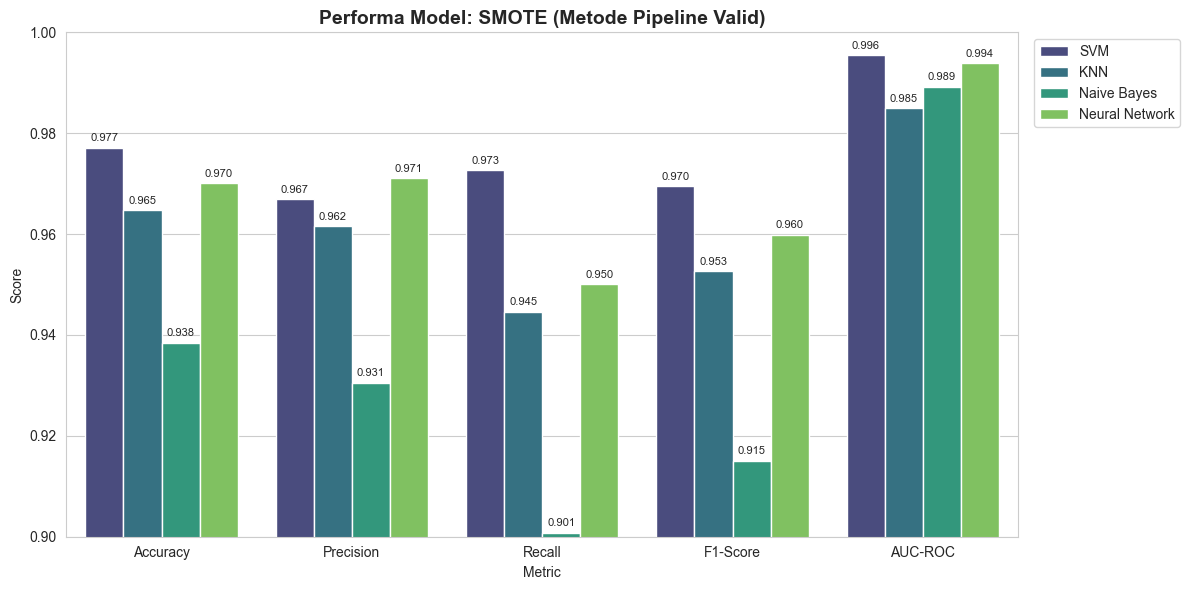

   -> Grafik Bar Chart (SMOTE) selesai.
2. SMOTE: Analisis Variasi K-Fold (Pipeline)... (Harap Tunggu)


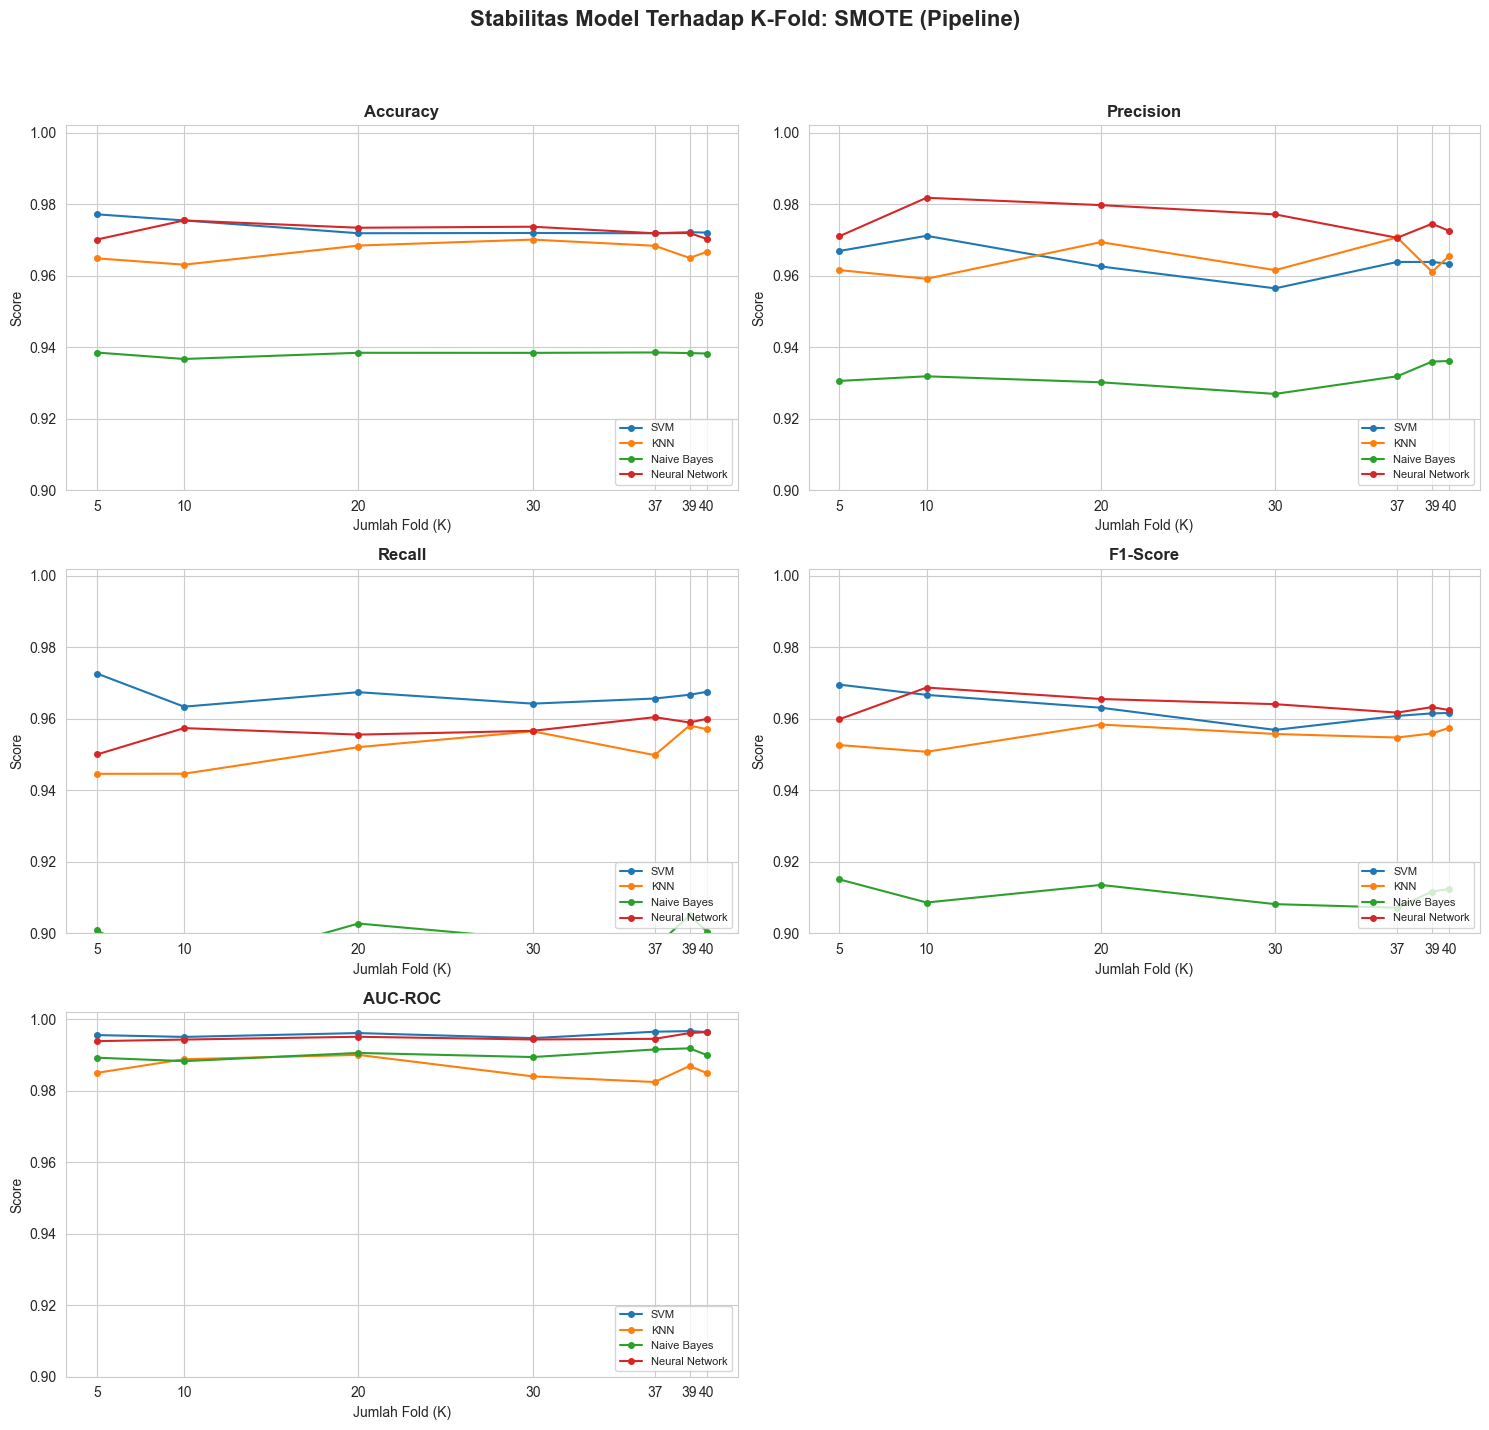

   -> Grafik Fig.4 (SMOTE) selesai.

PROSES ANALISIS METODE: ROS (VALID PIPELINE)
1. ROS: Menghitung Metrik Model (5-Fold)...


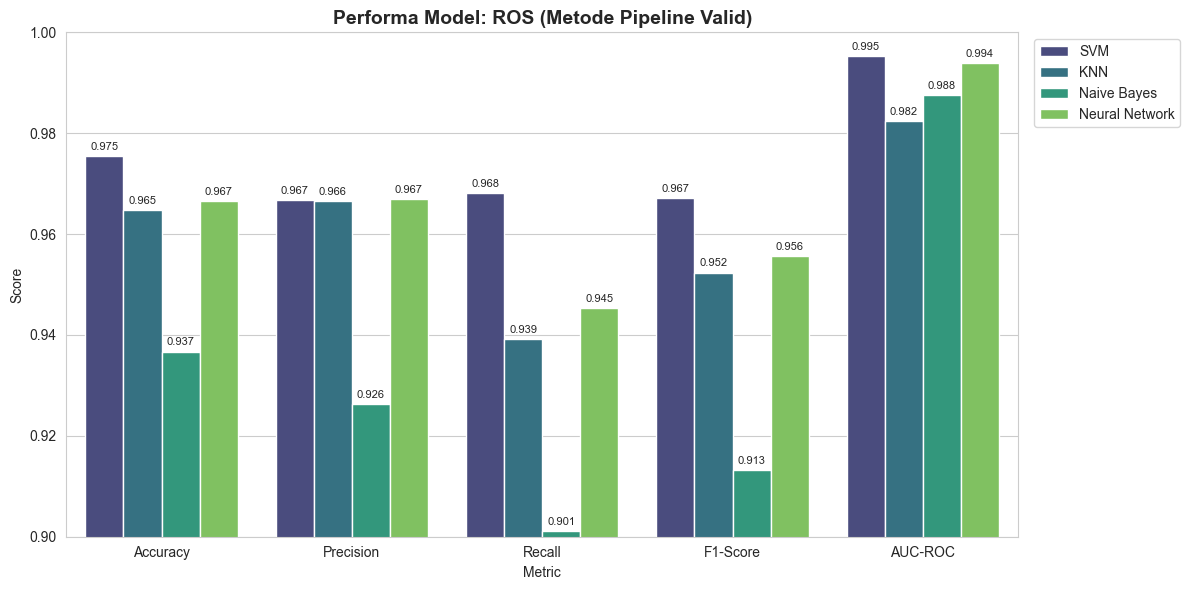

   -> Grafik Bar Chart (ROS) selesai.
2. ROS: Analisis Variasi K-Fold (Pipeline)... (Harap Tunggu)


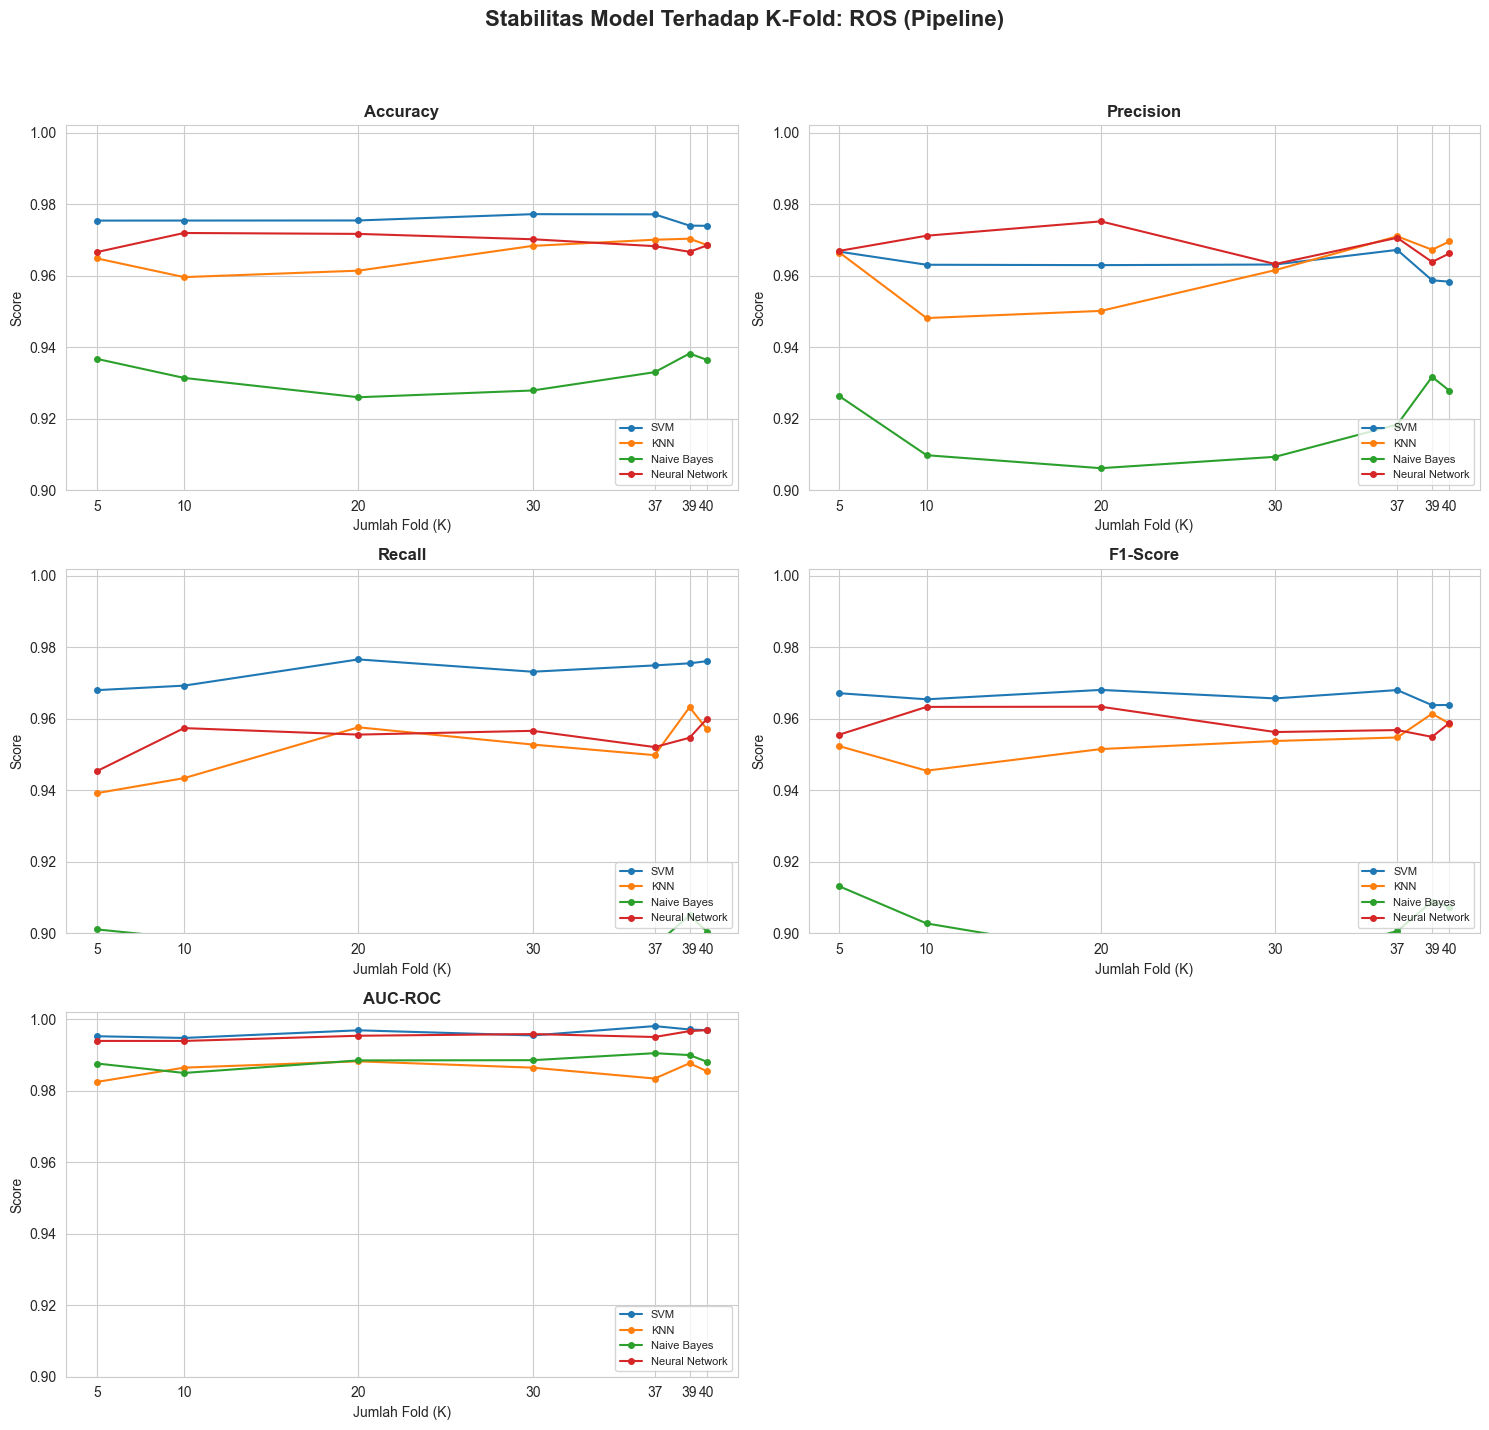

   -> Grafik Fig.4 (ROS) selesai.

PROSES ANALISIS METODE: SMOTE-ENN (VALID PIPELINE)
1. SMOTE-ENN: Menghitung Metrik Model (5-Fold)...


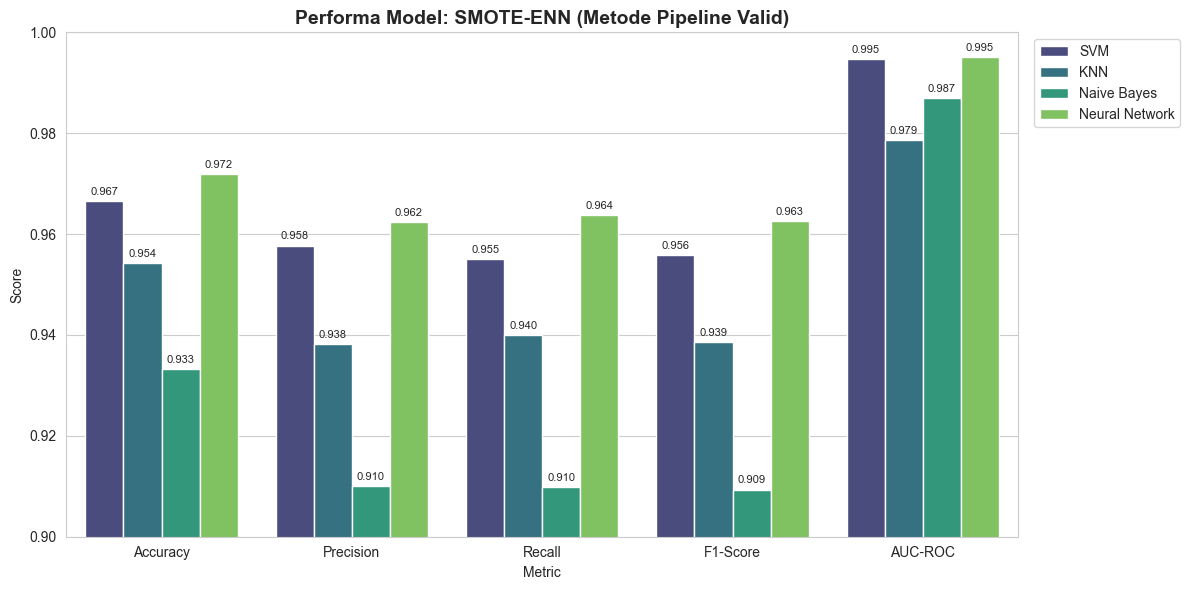

   -> Grafik Bar Chart (SMOTE-ENN) selesai.
2. SMOTE-ENN: Analisis Variasi K-Fold (Pipeline)... (Harap Tunggu)


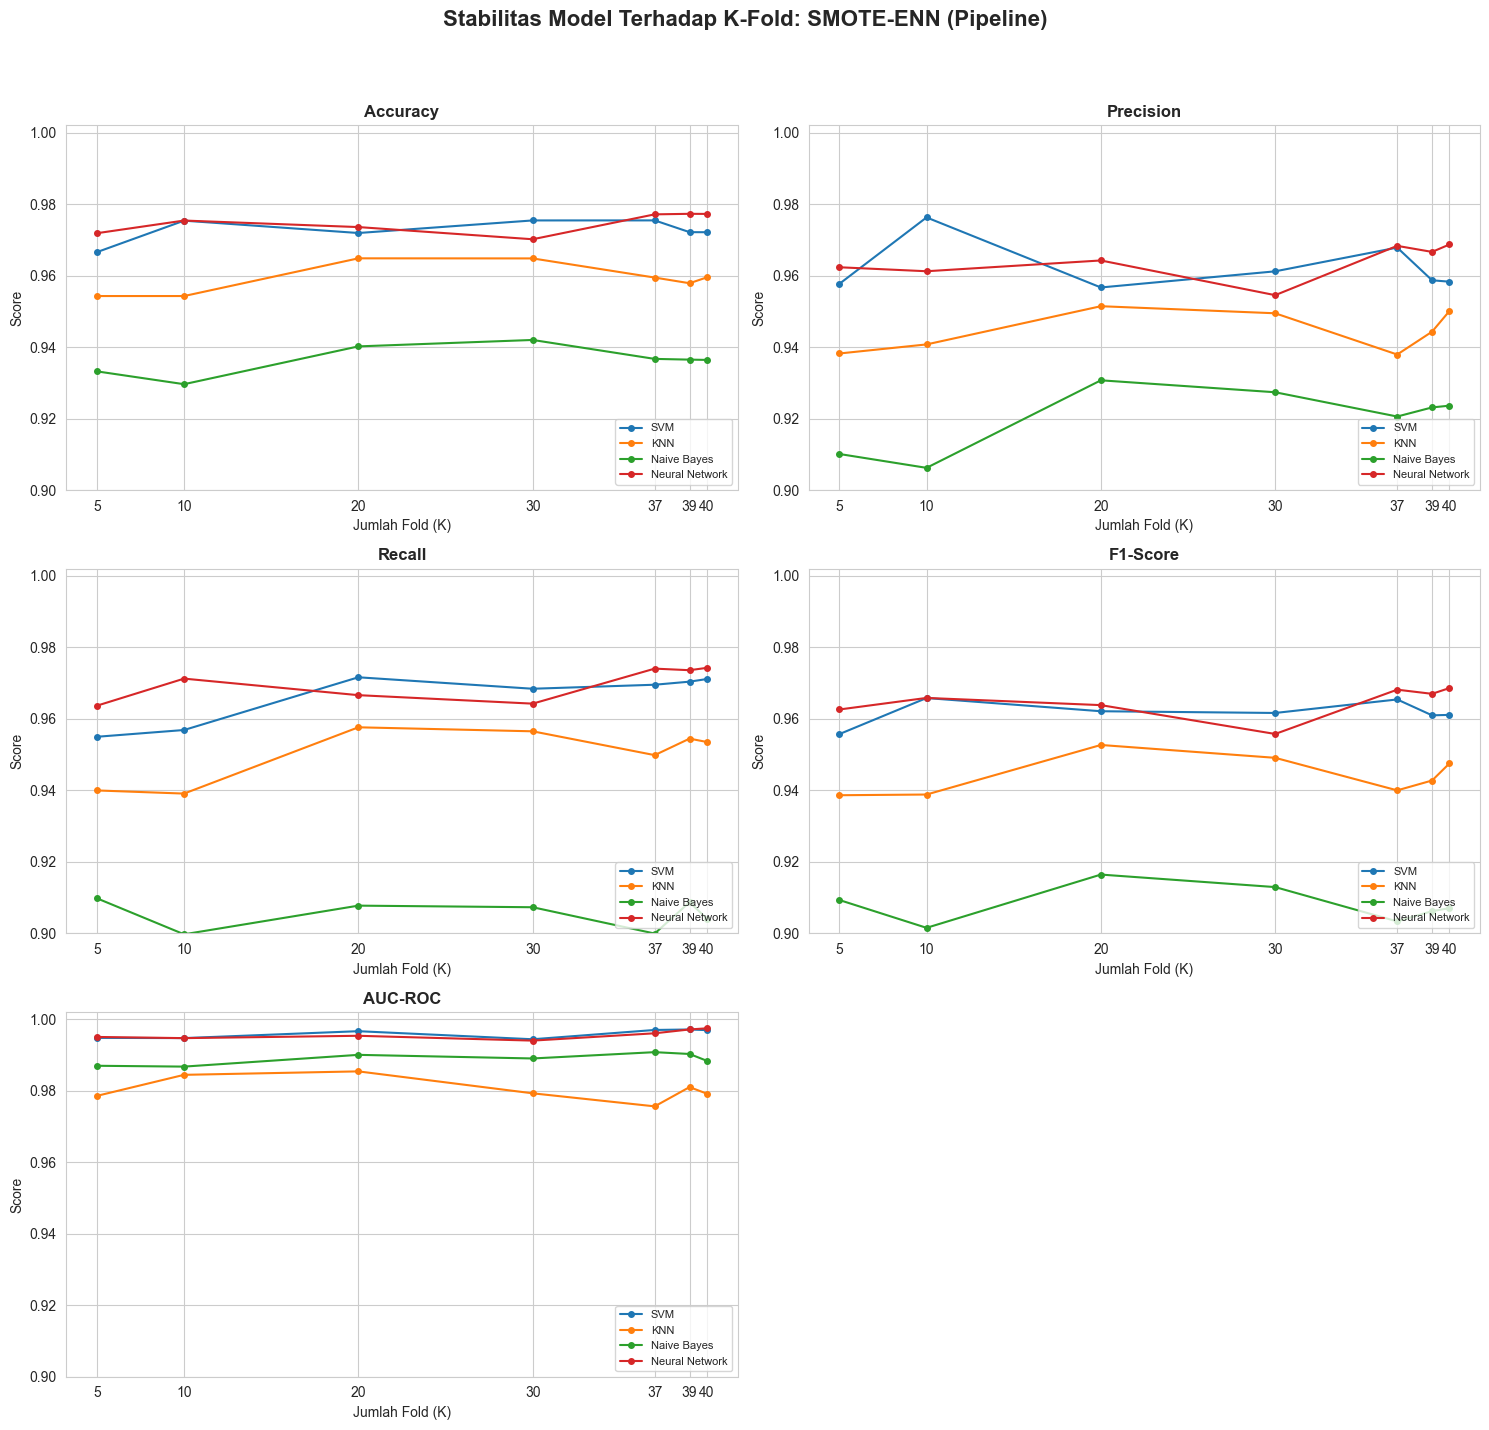

   -> Grafik Fig.4 (SMOTE-ENN) selesai.


In [4]:
# ==========================================
# 3. EKSEKUSI LOOP UTAMA (PIPELINE BASED)
# ==========================================

for res_name, resampler in resamplers.items():
    print(f"\n{'='*60}")
    print(f"PROSES ANALISIS METODE: {res_name} (VALID PIPELINE)")
    print(f"{'='*60}")
    
    # --- BAGIAN A: BAR CHART (5-FOLD) ---
    print(f"1. {res_name}: Menghitung Metrik Model (5-Fold)...")
    kf_5 = KFold(n_splits=5, shuffle=True, random_state=42)
    split_results = []
    
    for model_name, model in models.items():
        pipeline = ImbPipeline([('res', resampler), ('mod', model)])
        
        scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
        scores = cross_validate(pipeline, X_scaled, y, cv=kf_5, scoring=scoring, n_jobs=-1)
        
        split_results.append({
            "Model": model_name,
            "Accuracy": np.mean(scores['test_accuracy']),
            "Precision": np.mean(scores['test_precision']),
            "Recall": np.mean(scores['test_recall']),
            "F1-Score": np.mean(scores['test_f1']),
            "AUC-ROC": np.mean(scores['test_roc_auc'])
        })
        
        final_results_storage.append({
            "Metode Resampling": res_name,
            "Model": model_name,
            "Skor AUC-ROC": np.mean(scores['test_roc_auc'])
        })

    # Visualisasi A: Bar Chart 
    df_split = pd.DataFrame(split_results)
    df_melted = df_split.melt(id_vars="Model", var_name="Metric", value_name="Score")
    
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x="Metric", y="Score", hue="Model", data=df_melted, palette="viridis")
    plt.ylim(0.90, 1.0) 
    plt.title(f"Performa Model: {res_name} (Metode Pipeline Valid)", fontsize=14, fontweight='bold')
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', padding=3, fontsize=8)
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    print(f"   -> Grafik Bar Chart ({res_name}) selesai.")

    # --- BAGIAN B: LINE CHART FIG. 4 (VARIASI K-FOLD) ---
    print(f"2. {res_name}: Analisis Variasi K-Fold (Pipeline)... (Harap Tunggu)")
    history = {m: {'acc': [], 'prec': [], 'rec': [], 'f1': [], 'auc': []} for m in models}

    for k in k_values_fig4:
        kf_k = KFold(n_splits=k, shuffle=True, random_state=42)
        for model_name, model in models.items():
            pipeline = ImbPipeline([('res', resampler), ('mod', model)])
            scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
            scores = cross_validate(pipeline, X_scaled, y, cv=kf_k, scoring=scoring, n_jobs=-1)
            
            history[model_name]['acc'].append(np.mean(scores['test_accuracy']))
            history[model_name]['prec'].append(np.mean(scores['test_precision']))
            history[model_name]['rec'].append(np.mean(scores['test_recall']))
            history[model_name]['f1'].append(np.mean(scores['test_f1']))
            history[model_name]['auc'].append(np.mean(scores['test_roc_auc']))

    # Visualisasi B: 5 Subplots
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    fig.suptitle(f'Stabilitas Model Terhadap K-Fold: {res_name} (Pipeline)', fontsize=16, fontweight='bold')
    
    metrics_map = [('Accuracy', 'acc', axes[0,0]), ('Precision', 'prec', axes[0,1]),
                   ('Recall', 'rec', axes[1,0]), ('F1-Score', 'f1', axes[1,1]), ('AUC-ROC', 'auc', axes[2,0])]
    fig.delaxes(axes[2, 1])

    for title, key, ax in metrics_map:
        for model_name in models.keys():
            ax.plot(k_values_fig4, history[model_name][key], marker='o', linestyle='-', label=model_name, markersize=4)
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlabel('Jumlah Fold (K)')
        ax.set_ylabel('Score')
        ax.set_ylim(0.90, 1.002)
        ax.legend(loc='lower right', fontsize=8)
        ax.set_xticks(k_values_fig4)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    print(f"   -> Grafik Fig.4 ({res_name}) selesai.")


=== 4. KESIMPULAN AKHIR: PERBANDINGAN ANTAR METODE ===


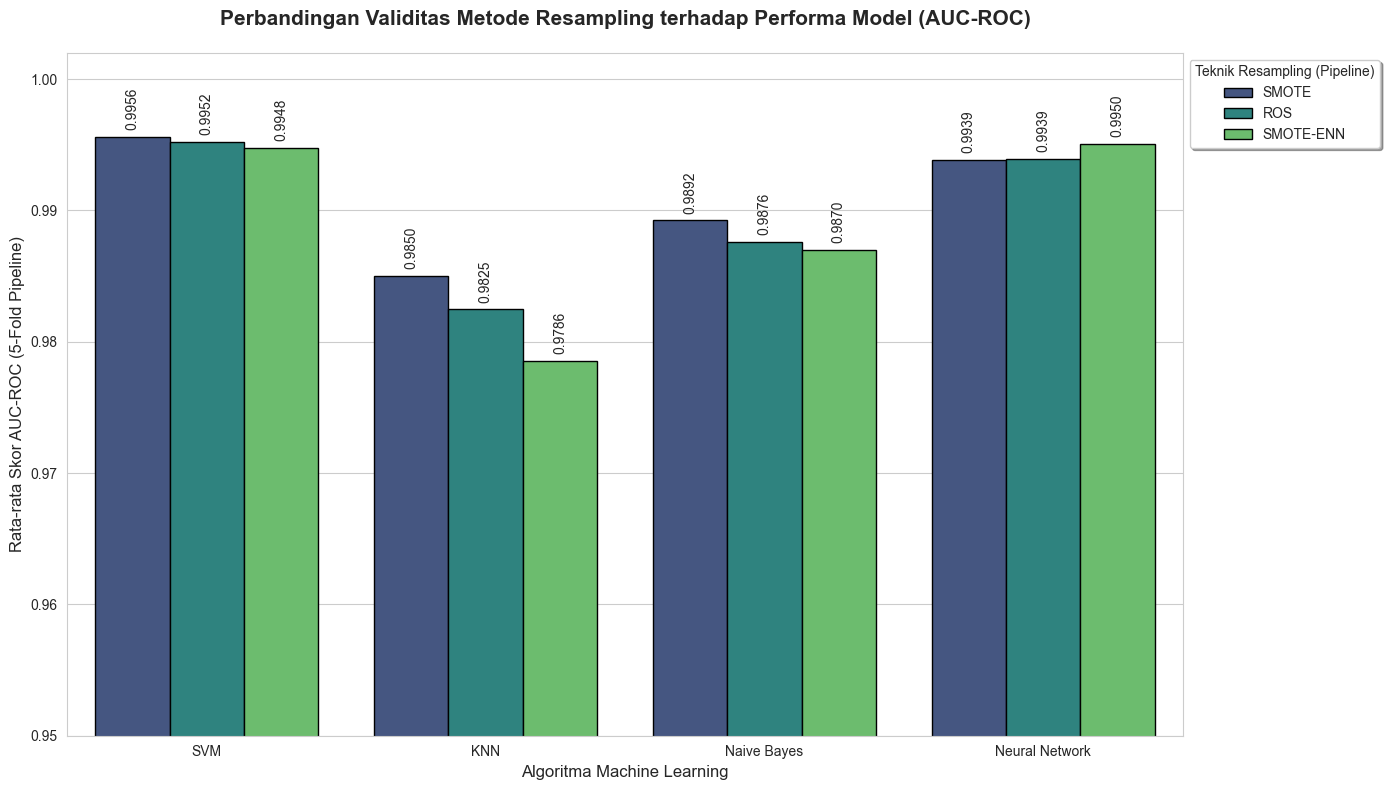


############################################################
Metodologi Terbaik:
1. Model Paling Robust: SVM
2. Metode Resampling:   SMOTE
3. Skor AUC-ROC Valid:  0.99556
############################################################


In [5]:
# ==========================================
# 4. VISUALISASI FINAL: HEAD-TO-HEAD (VALID)
# ==========================================
print("\n" + "="*60)
print("=== 4. KESIMPULAN AKHIR: PERBANDINGAN ANTAR METODE ===")
print("="*60)

df_final = pd.DataFrame(final_results_storage)

plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=df_final,
    x="Model",
    y="Skor AUC-ROC",
    hue="Metode Resampling",
    palette="viridis",
    edgecolor="black",
    linewidth=1
)

plt.title("Perbandingan Validitas Metode Resampling terhadap Performa Model (AUC-ROC)", fontsize=15, fontweight='bold', pad=20)
plt.ylim(0.95, 1.002) 
plt.ylabel("Rata-rata Skor AUC-ROC (5-Fold Pipeline)", fontsize=12)
plt.xlabel("Algoritma Machine Learning", fontsize=12)
plt.legend(title="Teknik Resampling (Pipeline)", bbox_to_anchor=(1.0, 1), loc='upper left', frameon=True, shadow=True)

for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', padding=5, fontsize=10, rotation=90)

plt.tight_layout()
plt.show()

best_row = df_final.loc[df_final['Skor AUC-ROC'].idxmax()]
print("\n" + "#"*60)
print("Metodologi Terbaik:")
print(f"1. Model Paling Robust: {best_row['Model']}")
print(f"2. Metode Resampling:   {best_row['Metode Resampling']}")
print(f"3. Skor AUC-ROC Valid:  {best_row['Skor AUC-ROC']:.5f}")
print("#"*60)